In [1]:
from cd_v_partition.causal_discovery import ges_local_learn, damga_local_learn, pc_local_learn, rfci_local_learn
from cd_v_partition.utils import get_scores, get_confusion_matrix, shd
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Detecting 3 CUDA device(s).


## Observational Data

### Load Sachs dataset generated from scratch using the separate .csv files from the Sachs paper.
 Protein names are "praf", "pmek","plcg","PIP2","PIP3","p44/42","pakts473",  "PKA",  "PKC",  "P38", "pjnk"

In [2]:
df = pd.read_csv("sachs_raw.csv", sep=',',header=0)
df = df.rename(columns={"praf":1,  "pmek":2, "plcg":3,  "PIP2":4,  "PIP3":5,  "p44/42":6,  "pakts473":7,  "PKA":8,  "PKC":9,  "P38":10, "pjnk":11})
num_nodes = df.shape[1] - 1
df_obs = df.drop(df[df.target >0].index)
dag_edges = [["plcg", "PIP3"], ["PIP3", "PIP2"], ["plcg", "PIP2"], ["PKC", "P38"], ["PKC", "pmek"], ["PKC","pjnk"], ["PKC", "praf"], ["PKC", "PKA"],
             ["PKA", "P38"], ["PKA", "pjnk"], ["PKA", "pakts473"], ["PKA", "p44/42"], ["PKA", "pmek"], ["PKA", "praf"],
             ["praf","pmek"], ["pmek", "p44/42" ], ["p44/42","pakts473"]]
dag = nx.from_edgelist(dag_edges, create_using=nx.DiGraph)
dag =nx.adjacency_matrix(dag, nodelist=["praf",  "pmek", "plcg",  "PIP2",  "PIP3",  "p44/42",  "pakts473",  "PKA",  "PKC",  "P38", "pjnk"]).todense()

### Estimate DAGs using CD algs

In [3]:
est_dag_ges = ges_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)
est_dag_dagma = damga_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)
est_dag_pc = pc_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)
est_dag_rfci = rfci_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)

s = get_scores(['GES'], [est_dag_ges], dag)
print(get_confusion_matrix(est_dag_ges, dag))
s = get_scores(['DAGMA'], [est_dag_dagma], dag)
print(get_confusion_matrix(est_dag_dagma, dag))
s = get_scores(['PC'], [est_dag_ges], dag)
print(get_confusion_matrix(est_dag_pc, dag))
s = get_scores(['RFCI'], [est_dag_rfci], dag)
print(get_confusion_matrix(est_dag_rfci, dag))

  0%|          | 0/180000.0 [00:00<?, ?it/s]

GES SHD: 14.0 SID: 0 AUC: 0.45269436445907035, TPR,FPR: (0.35294117647058826, 0.0673076923076923)
{'tn': 97, 'fp': 11, 'fn': 7, 'tp': 6}
DAGMA SHD: 11.5 SID: 0 AUC: 0.5164354362215324, TPR,FPR: (0.4117647058823529, 0.057692307692307696)
{'tn': 98, 'fp': 10, 'fn': 6, 'tp': 7}
PC SHD: 14.0 SID: 0 AUC: 0.45269436445907035, TPR,FPR: (0.35294117647058826, 0.0673076923076923)
{'tn': 93, 'fp': 8, 'fn': 11, 'tp': 9}
RFCI SHD: 15.0 SID: 0 AUC: 0.29608653378706856, TPR,FPR: (0.17647058823529413, 0.0673076923076923)
{'tn': 97, 'fp': 14, 'fn': 7, 'tp': 3}


In [4]:
def vis_graph(adj_mat, layout, ax):
    G = nx.from_numpy_array(adj_mat, create_using=nx.DiGraph)
    
    nx.draw(G, pos=layout, ax=ax, with_labels=True, node_size=100)

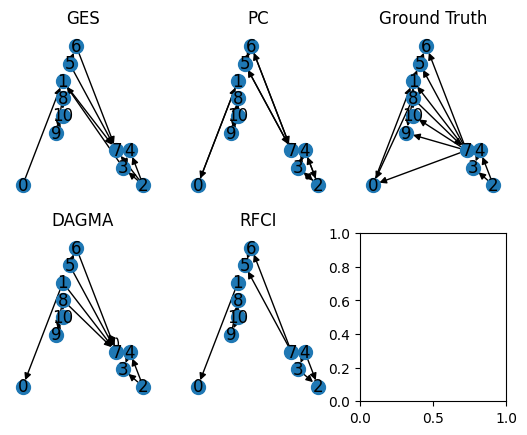

In [5]:
fig, axs = plt.subplots(2,3)
G_init = nx.from_numpy_array(dag, create_using=nx.DiGraph)
layout = nx.planar_layout(G_init)
vis_graph(est_dag_ges,layout,axs[0][0])
vis_graph(est_dag_dagma,layout,axs[1][0])
vis_graph(est_dag_pc,layout,axs[0][1])
vis_graph(est_dag_rfci,layout,axs[1][1])
vis_graph(dag,layout,axs[0][2])

axs[0][0].set_title("GES")
axs[1][0].set_title("DAGMA")
axs[0][1].set_title("PC")
axs[1][1].set_title("RFCI")
axs[0][2].set_title("Ground Truth")

plt.show()
df = df.rename(columns={"praf":1,  "pmek":2, "plcg":3,  "PIP2":4,  "PIP3":5,  "p44/42":6,  "pakts473":7,  "PKA":8,  "PKC":9,  "P38":10, "pjnk":11})

### Follow steps in bnlearn to estimate CPDAG from observational data using R
https://www.bnlearn.com/research/sachs05/

In [6]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
pcalg = importr("pcalg")
base = importr("base")
bnlearn = importr("bnlearn")
from rpy2.robjects import pandas2ri

In [7]:
data = df_obs.drop(columns=['target'])
with (ro.default_converter + pandas2ri.converter).context():
    dsachs = bnlearn.discretize(data, method = "hartemink",
            breaks = 3, ibreaks = 60, idisc = "quantile")

In [8]:
with (ro.default_converter + pandas2ri.converter).context():
    ro.r.assign("dsachs", dsachs)
    rcode = 'boot = boot.strength(dsachs, R = 500, algorithm = "hc", algorithm.args = list(score = "bde", iss = 10)) \n avg.boot = averaged.network(boot, threshold = 0.85) \n skeleton(avg.boot)'
    avg_boot = ro.r(rcode) 

In [9]:
flip=0
boot_r_source = []
boot_r_sink = []
for node in avg_boot['arcs']:
    if flip%2 == 0:
        boot_r_source.append(int(node)-1)
    else:
        boot_r_sink.append(int(node)-1)
    flip+=1
boot_r_edges = list(zip(boot_r_source, boot_r_sink))
dag_boot_r = nx.from_edgelist(boot_r_edges)
dag_boot_r = nx.adjacency_matrix(dag_boot_r, np.arange(11)).todense()

        

### Visualize R bootstrap CPDAG, GES DAG and DAGMA DAG compared to ground truth

Good news: DAGMA and GES, which work on the raw continuous data (no bootstrap), estimates the same/similar skeleton as R (bootstrap)

Text(0.5, 1.0, 'Ground Truth')

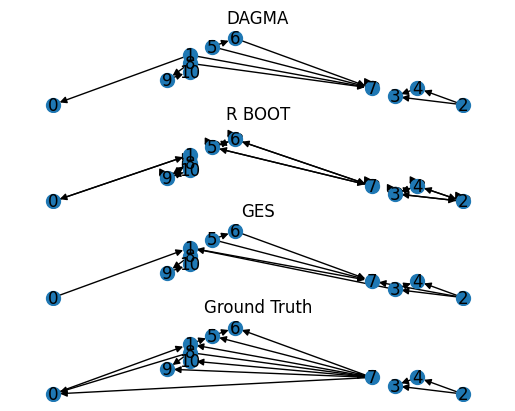

In [10]:
fig, axs = plt.subplots(4)
vis_graph(est_dag_dagma,layout,axs[0])
vis_graph(dag_boot_r,layout,axs[1])
vis_graph(est_dag_ges,layout,axs[2])
vis_graph(dag,layout,axs[3])

axs[0].set_title("DAGMA")
axs[1].set_title("R BOOT")
axs[2].set_title("GES")
axs[3].set_title("Ground Truth")

In [11]:
s = get_scores(['DAGMA'], [est_dag_dagma], dag)
print(get_confusion_matrix(est_dag_dagma, dag))
s = get_scores(['R BOOT'], [dag_boot_r], dag)
print(get_confusion_matrix(dag_boot_r, dag))

DAGMA SHD: 11.5 SID: 0 AUC: 0.5164354362215324, TPR,FPR: (0.4117647058823529, 0.057692307692307696)
{'tn': 98, 'fp': 10, 'fn': 6, 'tp': 7}
R BOOT SHD: 22.5 SID: 0 AUC: 0.452936147385714, TPR,FPR: (0.5294117647058824, 0.19230769230769232)
{'tn': 84, 'fp': 8, 'fn': 20, 'tp': 9}


## Interventional Data

### Follow steps in bnlearn with interventional data using the pre discretized dataset sachs.interventional.txt

This completely recovers all the true postives (TP=17) 

In [12]:
with (ro.default_converter + pandas2ri.converter).context():
    rcode = 'sachs.modelstring <- paste("[PKC][PKA|PKC][Raf|PKC:PKA][Mek|PKC:PKA:Raf]","[Erk|Mek:PKA][Akt|Erk:PKA][P38|PKC:PKA]", "[Jnk|PKC:PKA][Plcg][PIP3|Plcg][PIP2|Plcg:PIP3]", sep = "")\n dag.sachs = model2network(sachs.modelstring)'
    model = ro.r(rcode)
    rcode = 'isachs1 = read.table("sachs.interventional.txt", header = TRUE, colClasses = "factor")\n INT = sapply(1:11, function(x) {which(isachs1$INT == x) })\n nodes = names(isachs1)[1:11]\n names(INT) = nodes\n start = random.graph(nodes = nodes, method = "melancon", num = 500, burn.in = 10^5, every = 100)\n netlist = lapply(start, function(net) { tabu(isachs1[, 1:11], score = "mbde", exp = INT,iss = 1, start = net, tabu = 50)})\n intscore = custom.strength(netlist, nodes = nodes,cpdag = FALSE)'
    most_time_intensive_step = ro.r(rcode)
    rcode = 'averaged.network(intscore)'
    dag_r_int = ro.r(rcode)  

In [13]:
mapping = {"Raf":1,  "Mek":2, "Plcg":3,  "PIP2":4,  "PIP3":5,  "Erk":6,  "Akt":7,  "PKA":8,  "PKC":9,  "P38":10, "Jnk":11}
flip=0
boot_r_source = []
boot_r_sink = []
num_edges = len(dag_r_int['arcs'])/2
for node in dag_r_int['arcs']:
    if flip // num_edges == 0:
        boot_r_source.append(mapping[node])
    else:
       boot_r_sink.append(mapping[node])
    flip+=1
boot_r_edges = list(zip(boot_r_source, boot_r_sink))
int_dag_boot_r = nx.from_edgelist(boot_r_edges)
int_dag_boot_r = nx.adjacency_matrix(int_dag_boot_r, np.arange(1,12)).todense()

In [14]:
print(get_confusion_matrix(dag, int_dag_boot_r))
print(shd(dag, int_dag_boot_r))

{'tn': 71, 'fp': 33, 'fn': 0, 'tp': 17}
33


## Follow steps in bnlearn with interventional data but use sachs_raw dataset that I create and discretize

Strangely, these results do not agree with the results above. Which means whatever discretization used inn sachs.interventional.txt is different then for the observational data....this is annoyinng because it is not documented how this file was created

TP=12

In [15]:
# Looks like sachs.interventional.txt is discretized in a slightly different way
vec = df['target']
data = df.drop(columns=['target'])
with (ro.default_converter + pandas2ri.converter).context():
    isachs = bnlearn.discretize(data, method = "hartemink",
            breaks = 3, ibreaks = 60, idisc = "quantile")
    ro.r.assign("isachs2", isachs)
    ro.r.assign("vec", vec)
    rcode = 'isachs2$INT <- vec\n sachs.modelstring <- paste("[PKC][PKA|PKC][Raf|PKC:PKA][Mek|PKC:PKA:Raf]","[Erk|Mek:PKA][Akt|Erk:PKA][P38|PKC:PKA]", "[Jnk|PKC:PKA][Plcg][PIP3|Plcg][PIP2|Plcg:PIP3]", sep = "")\n dag.sachs = model2network(sachs.modelstring)'
    model = ro.r(rcode)
    rcode = 'INT = sapply(1:11, function(x) {which(isachs2$INT == x) })\n nodes = names(isachs2)[1:11]\n names(INT) = nodes\n start = random.graph(nodes = nodes, method = "melancon", num = 500, burn.in = 10^5, every = 100)\n netlist = lapply(start, function(net) { tabu(isachs2[, 1:11], score = "mbde", exp = INT,iss = 1, start = net, tabu = 50)})\n intscore = custom.strength(netlist, nodes = nodes,cpdag = FALSE)'
    most_time_intensive_step = ro.r(rcode)
    rcode = 'averaged.network(intscore)'
    dag_r_int = ro.r(rcode) 

In [16]:
# Ok I'm not sure how to interpret the output of the discretization (isachs2), this is likely why the two results don't agree (also I didn't add an INT vector)
rcode='print(head(isachs1))\nprint(head(isachs2))'
ro.r(rcode)

  Raf Mek Plcg PIP2 PIP3 Erk Akt PKA PKC P38 Jnk INT
1   1   1    1    2    3   2   1   3   1   2   1   8
2   1   1    1    1    3   3   2   3   1   2   1   8
3   1   1    2    2    3   2   1   3   2   1   1   8
4   1   1    1    1    3   2   1   3   1   3   1   8
5   1   1    1    1    3   2   1   3   1   1   1   8
6   1   1    1    1    2   2   1   3   1   2   1   8
           1             2           3       4           5        6        7
1   [1,42.6] (5.81667,143]    [1,10.9] [1,161] (29.4,1084] [1,24.4] [1,79.1]
2   [1,42.6] (5.81667,143] (10.9,93.1] [1,161]    [1,13.5] [1,24.4] [1,79.1]
3 (42.6,204] (5.81667,143] (10.9,93.1] [1,161]    [1,13.5] [1,24.4] [1,79.1]
4 (42.6,204] (5.81667,143] (10.9,93.1] [1,161]    [1,13.5] [1,24.4] [1,79.1]
5   [1,42.6] (5.81667,143]    [1,10.9] [1,161] (13.5,29.4] [1,24.4] [1,79.1]
6   [1,42.6]   [1,5.81667] (10.9,93.1] [1,161]    [1,13.5] [1,24.4] [1,79.1]
           8              9        10          11 INT
1 (379,1472] (1.02,26.4143] (5.33,50

In [38]:
isachs_new = pd.DataFrame(columns=isachs.columns)
for column in isachs:
    vals = list(set(isachs[column]))
    sorted_list = []
    for v in vals:
        sorted_list.append(float(v.split(",")[0][1:]))
    sorted_list, vals = zip(*sorted(zip(sorted_list, vals)))
    vals=list(vals)
    column_values = []
    for i in np.arange(isachs[column].shape[0]):
        column_values.append(vals.index(isachs[column][i])+1)
    isachs_new[column] = column_values
isachs_new["INT"] = vec
isachs_new.to_csv("sachs.interventional_new.txt", sep=' ', header=True, index=False)
with (ro.default_converter + pandas2ri.converter).context():
    rcode = 'sachs.modelstring <- paste("[PKC][PKA|PKC][Raf|PKC:PKA][Mek|PKC:PKA:Raf]","[Erk|Mek:PKA][Akt|Erk:PKA][P38|PKC:PKA]", "[Jnk|PKC:PKA][Plcg][PIP3|Plcg][PIP2|Plcg:PIP3]", sep = "")\n dag.sachs = model2network(sachs.modelstring)'
    model = ro.r(rcode)
    rcode = 'isachs3 = read.table("sachs.interventional_new.txt", header = TRUE, colClasses = "factor")\nINT = sapply(1:11, function(x) {which(isachs3$INT == x) })\n nodes = names(isachs3)[1:11]\n names(INT) = nodes\n start = random.graph(nodes = nodes, method = "melancon", num = 500, burn.in = 10^5, every = 100)\n netlist = lapply(start, function(net) { tabu(isachs3[, 1:11], score = "mbde", exp = INT,iss = 1, start = net, tabu = 50)})\n intscore = custom.strength(netlist, nodes = nodes,cpdag = FALSE)'
    most_time_intensive_step = ro.r(rcode)
    rcode = 'averaged.network(intscore)'
    dag_r_int = ro.r(rcode) 

In [44]:
flip=0
boot_r_source = []
boot_r_sink = []
num_edges = len(dag_r_int['arcs'])/2
for node in dag_r_int['arcs']:
    if flip // num_edges == 0:
        boot_r_source.append(int(node[1:]))
    else:
       boot_r_sink.append(int(node[1:]))
    flip+=1
boot_r_edges = list(zip(boot_r_source, boot_r_sink))
my_int_dag_boot_r = nx.from_edgelist(boot_r_edges)
my_int_dag_boot_r = nx.adjacency_matrix(my_int_dag_boot_r, np.arange(1,12)).todense()

In [45]:
print(get_confusion_matrix(dag, my_int_dag_boot_r))
print(shd( dag, my_int_dag_boot_r))

{'tn': 74, 'fp': 30, 'fn': 5, 'tp': 12}
35


Text(0.5, 1.0, 'Ground Truth')

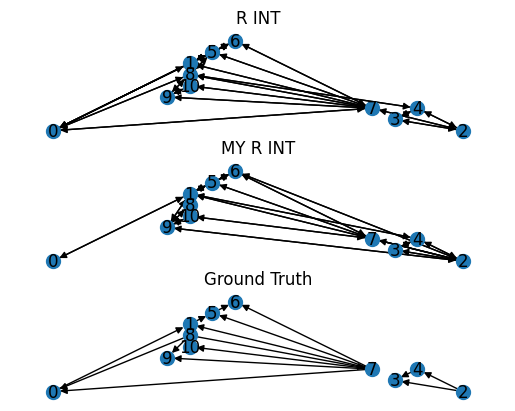

In [46]:
fig, axs = plt.subplots(3)
vis_graph(int_dag_boot_r,layout,axs[0])
vis_graph(my_int_dag_boot_r,layout,axs[1])
vis_graph(dag,layout,axs[2])

axs[0].set_title("R INT")
axs[1].set_title("MY R INT")
axs[2].set_title("Ground Truth")

### DAGMA and GIES with interventional data and no discretization

In [ ]:
# No change compared to observational version
est_dag_dagma_int = damga_local_learn([np.ones((num_nodes, num_nodes)), df], use_skel=False)
print(get_confusion_matrix(dag, est_dag_dagma_int))
print(shd( dag, est_dag_dagma_int))

  0%|          | 0/180000.0 [00:00<?, ?it/s]

{'tn': 96, 'fp': 8, 'fn': 11, 'tp': 6}
19


In [21]:
# Fixed indexing in GIES so that interventional data now helps!
# Use reg from hyperparam optimization (for now just use the highest TP and reasonable SHD)
est_dag_gies_int = ges_local_learn([np.ones((num_nodes, num_nodes)), df], use_skel=False, reg=3.5)

print(get_confusion_matrix(dag, est_dag_ges))
print(shd( dag, est_dag_ges))

print(get_confusion_matrix(dag, est_dag_gies_int))
print(shd( dag, est_dag_gies_int))

{'tn': 97, 'fp': 7, 'fn': 11, 'tp': 6}
18
{'tn': 89, 'fp': 15, 'fn': 7, 'tp': 10}
22


### GIES from DCDI implementation

In [22]:
dcdi_gies_dag = np.load("./DAG.npy")
print(get_confusion_matrix(dag, dcdi_gies_dag))
print(shd( dag, dcdi_gies_dag))

{'tn': 73, 'fp': 31, 'fn': 6, 'tp': 11}
37


Text(0.5, 1.0, 'Ground Truth')

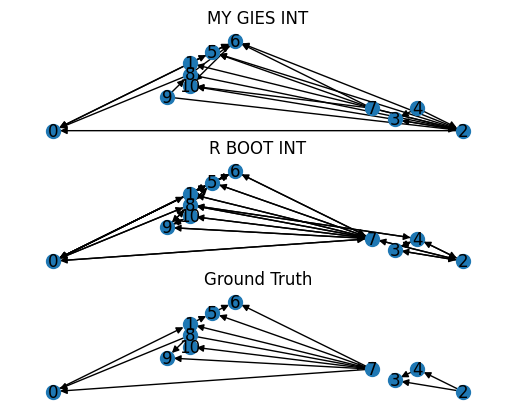

In [23]:
fig, axs = plt.subplots(3)
vis_graph(est_dag_gies_int,layout,axs[0])
vis_graph(int_dag_boot_r,layout,axs[1])
vis_graph(dag,layout,axs[2])

axs[0].set_title("MY GIES INT")
axs[1].set_title("R BOOT INT")
axs[2].set_title("Ground Truth")

In [29]:
# Try discretized intervetnional data
df_int_discretized = pd.read_csv("sachs.interventional.txt", header=0, sep=' ')
df_int_discretized=df_int_discretized.rename(mapper={"INT":"target"}, axis=1)
est_dag_gies_int_d = ges_local_learn([np.ones((num_nodes, num_nodes)), df_int_discretized], use_skel=False)
print(get_confusion_matrix(dag, est_dag_gies_int_d))
print(shd( dag, est_dag_gies_int_d))

est_dag_dagma_int_d = damga_local_learn([np.ones((num_nodes, num_nodes)), df_int_discretized], use_skel=False)
print(get_confusion_matrix(dag, est_dag_dagma_int_d))
print(shd( dag, est_dag_dagma_int_d))


{'tn': 73, 'fp': 31, 'fn': 6, 'tp': 11}
37


  0%|          | 0/180000.0 [00:00<?, ?it/s]

{'tn': 98, 'fp': 6, 'fn': 14, 'tp': 3}
20


### TODO: Use DCDI so that we can accounnt for interventional data using a gradient based method

# Hyperparameter selection

In [ ]:
from sklearn.model_selection import train_test_split
lambda_range = np.arange(-4,10,0.5)
train, holdout = train_test_split(df, test_size=0.2)

for val in lambda_range:
    est_dag_gies_int = ges_local_learn([np.ones((num_nodes, num_nodes)), df], use_skel=False, reg=val)
    print(f'Lambda is {val}')
    print(get_confusion_matrix(dag, est_dag_gies_int))
    print(shd( dag, est_dag_gies_int))


Lambda is -4.0
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is -3.5
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is -3.0
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is -2.5
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is -2.0
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is -1.5
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is -1.0
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is -0.5
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is 0.0
{'tn': 62, 'fp': 42, 'fn': 4, 'tp': 13}
46
Lambda is 0.5
{'tn': 81, 'fp': 23, 'fn': 8, 'tp': 9}
31
Lambda is 1.0
{'tn': 83, 'fp': 21, 'fn': 8, 'tp': 9}
29
Lambda is 1.5
{'tn': 85, 'fp': 19, 'fn': 8, 'tp': 9}
27
Lambda is 2.0
{'tn': 86, 'fp': 18, 'fn': 8, 'tp': 9}
26
Lambda is 2.5
{'tn': 86, 'fp': 18, 'fn': 8, 'tp': 9}
26
Lambda is 3.0
{'tn': 86, 'fp': 18, 'fn': 8, 'tp': 9}
26
Lambda is 3.5
{'tn': 89, 'fp': 15, 'fn': 7, 'tp': 10}
22
Lambda is 4.0
{'tn': 90, 'fp': 14, 'fn': 8, 'tp': 9}
22
Lambda is 4.5
{'tn': 90, 'fp':

# Notes

- bnlearn has code that recovers all the true edges of the graph. This notebook tries to replicate this an also uses other CD algorithms that do not require discretization
- DAGMA and GIES perform comparably to the R code from bnlearn on observational data. The problem arise when we incorporate interventional data
- The sachs folder in bnlearn contains a file sachs.interventional.txt which contains observational and interventional samples that are already discretized. With this they recover all edges in the true graph
- I created my version of the interventional dataset using the files from the sachs paper (I keep this as continuous)
- However running GIES and DAGMA on this data set only recovers 10 or 11 edges
- I also ran the discretized version of my dataset in R and only recover 12 edges rather than 17. Because there is no explanation of how sachs.interventional.txt is gennerated, I'm not sure I can reverse engineer the correct dataset